# 120. Chatbot - seq2seq language model

## Encoder-Decoder model

- Chatbot_data_for_Korean v1.0 dataset (https://github.com/songys/Chatbot_data) 을 이용한 Chatbot model 개발

- 챗봇 트레이닝용 문답 페어 11,876개  
- 일상다반사 - 0,
- 이별(부정) - 1,
- 사랑(긍정) - 2 로 레이블링  

<img src='https://github.com/ironmanciti/NLP_Lecture/raw/master/chatbot.png' width=600>

In [1]:
!pip install -q sentencepiece

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sentencepiece as spm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

In [3]:
LATENT_DIM = 128                # encoding space 의 latent dimensionality
EMBEDDING_DIM = 100

Train Data 불러오기

In [4]:
df = pd.read_csv('https://github.com/ironmanciti/NLP_Lecture/raw/master/data/ChatbotData.csv')
df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


Data 확인

In [6]:
df.iloc[:, [0, 1]].values

array([['12시 땡!', '하루가 또 가네요.'],
       ['1지망 학교 떨어졌어', '위로해 드립니다.'],
       ['3박4일 놀러가고 싶다', '여행은 언제나 좋죠.'],
       ...,
       ['흑기사 해주는 짝남.', '설렜겠어요.'],
       ['힘든 연애 좋은 연애라는게 무슨 차이일까?', '잘 헤어질 수 있는 사이 여부인 거 같아요.'],
       ['힘들어서 결혼할까봐', '도피성 결혼은 하지 않길 바라요.']], dtype=object)

Train 용 Question, Answer data 작성

In [7]:
All_texts = []    # sentencepiece tokenizer 학습에 사용
Q_texts = []        # Encoder 입력에 사용
A_texts = []        # Decoder 입력에 사용

for Q, A in df.iloc[:, [0, 1]].values:
    Q_texts.append(Q)
    A_texts.append(A)

All_texts = Q_texts + A_texts

print(len(All_texts), len(Q_texts), len(A_texts))
print("Question :")
print(Q_texts[:5])
print("Answer :")
print(A_texts[:5])

23646 11823 11823
Question :
['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
Answer :
['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.', '눈살이 찌푸려지죠.']


## Sentencepiece Tokenizer 학습을 위한 text file 생성

In [8]:
with open('chatbot_qna.txt', 'w', encoding='utf-8') as f:
    for line in All_texts:
        f.write(line + '\n')

In [9]:
input_file = 'chatbot_qna.txt'
pad_id = 0             #<pad> token을 0으로 설정
vocab_size = 5000      # vocab 사이즈
prefix = 'chatbot_qna' # 저장될 tokenizer 모델에 붙는 이름
bos_id=1               #<s> token을 1으로 설정
eos_id=2               #</s> token을 2으로 설정
unk_id=3               #<unknown> token을 3으로 설정

cmd = f'--input={input_file} \
--pad_id={pad_id} \
--bos_id={bos_id} \
--eos_id={eos_id} \
--unk_id={unk_id} \
--model_prefix={prefix} \
--vocab_size={vocab_size}'

spm.SentencePieceTrainer.Train(cmd)

학습 완료된 sentencepiece tokenizer Load

In [10]:
sp = spm.SentencePieceProcessor()
sp.Load(f'{prefix}.model')

True

In [11]:
sp.DecodeIds([170, 367, 10, 129, 16, 4])

'운 나한테이 될고.'

- Tokenize하기 전에 데이터 자체에 `<s>, </s>`를 넣어줘도 되지만, 패키지 자체에서 알아서 해주는 옵션(sp.SetEncodeExtraOptions)이 있습니다.

- `sp.SetEncodeExtraOptions('bos:eos')` : 문장 양 끝에 `<s> , </s>` 추가

In [12]:
sp.SetEncodeExtraOptions('bos:')   # 문장 처음에 <s>추가 --> Decoder Input에 사용
pieces = sp.encode_as_pieces('아버지가 방에 들어가신다')
print(pieces)
ids = sp.encode_as_ids('아버지가 방에 들어가신다')
print(ids)
print(sp.DecodePieces(pieces))
print(sp.DecodeIds(ids))

['<s>', '▁아', '버', '지', '가', '▁방', '에', '▁들어가', '신', '다']
[1, 232, 2112, 14, 7, 1467, 31, 1665, 455, 57]
아버지가 방에 들어가신다
아버지가 방에 들어가신다


In [13]:
sp.SetEncodeExtraOptions(':eos')     # 문장 끝에 </s>추가  --> Decoder target에 사용
pieces = sp.encode_as_pieces('아버지가 방에 들어가신다')
print(pieces)
ids = sp.encode_as_ids('아버지가 방에 들어가신다')
print(ids)
print(sp.DecodePieces(pieces))
print(sp.DecodeIds(ids))

['▁아', '버', '지', '가', '▁방', '에', '▁들어가', '신', '다', '</s>']
[232, 2112, 14, 7, 1467, 31, 1665, 455, 57, 2]
아버지가 방에 들어가신다
아버지가 방에 들어가신다


### Question sequence 작성

In [14]:
Q_sequences = [sp.encode_as_ids(sent) for sent in Q_texts]

print(Q_sequences[:5])

[[4228, 299, 5, 4826, 72, 2], [291, 14, 933, 674, 1735, 2], [277, 1280, 2810, 76, 2964, 94, 2], [277, 1280, 2810, 76, 667, 2964, 94, 2], [5, 4549, 4549, 3, 1395, 64, 2]]


### Answer sequence input 작성

In [15]:
sp.SetEncodeExtraOptions('bos:')  # 1로 시작
A_sequences_inputs = [sp.encode_as_ids(sent) for sent in A_texts]

print(A_sequences_inputs[:5])

[[1, 282, 7, 113, 82, 23, 4], [1, 1459, 5, 3717, 4], [1, 293, 15, 385, 39, 207, 4], [1, 293, 15, 385, 39, 207, 4], [1, 208, 970, 10, 2434, 3090, 173, 14, 40, 4]]


### Answer sequence target 작성

In [16]:
sp.SetEncodeExtraOptions(':eos')  # 2로 종료
A_sequences_targets = [sp.encode_as_ids(sent) for sent in A_texts]

print(A_sequences_targets[:5])

[[282, 7, 113, 82, 23, 4, 2], [1459, 5, 3717, 4, 2], [293, 15, 385, 39, 207, 4, 2], [293, 15, 385, 39, 207, 4, 2], [208, 970, 10, 2434, 3090, 173, 14, 40, 4, 2]]


input text의  max length 지정

Target Text 의 최대 길이 : 56
Target Text 의 최대 길이 : 76


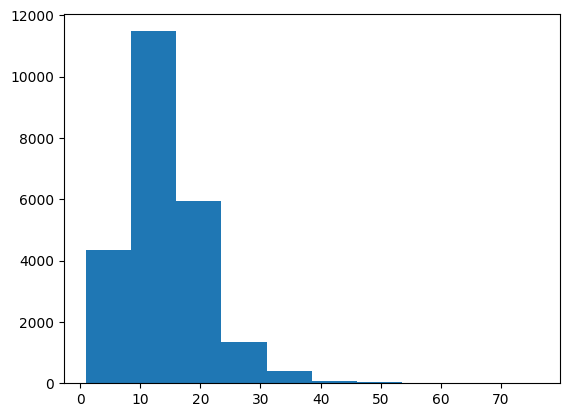

In [17]:
max_len_Q = max(len(s) for s in Q_texts)
print("Target Text 의 최대 길이 :", max_len_Q)

max_len_A = max(len(s) for s in A_texts)
print("Target Text 의 최대 길이 :", max_len_A)

plt.hist([len(s) for s in All_texts]);

Input sequence 의 최대 길이는 30 으로 정한다.

In [18]:
MAX_LEN = 30

## sequence padding


#### 주의 사항
- encoder 는 thought vector 생성 목적이므로 default (pre) 로 padding

- decoder 는 teacher forcing 을 해야하므로 post 로 padding

In [19]:
encoder_inputs = pad_sequences(Q_sequences, maxlen=MAX_LEN)
print("encoder input shape :", encoder_inputs.shape)
print("encoder_inputs[0] : ", encoder_inputs[1500])

decoder_inputs = pad_sequences(A_sequences_inputs,
                               maxlen=MAX_LEN, padding="post")
print("\ndecoder input shape :", decoder_inputs.shape)
print("decoder_inputs[0] : ", decoder_inputs[1500])

decoder_targets = pad_sequences(A_sequences_targets,
                                maxlen=MAX_LEN, padding="post")
print("\nencoder target shape :", decoder_targets.shape)
print("encoder_targets[0] : ", decoder_targets[1500])

encoder input shape : (11823, 30)
encoder_inputs[0] :  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  162 1680  318
 2391    2]

decoder input shape : (11823, 30)
decoder_inputs[0] :  [   1 1145   33 3040   45    4    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]

encoder target shape : (11823, 30)
encoder_targets[0] :  [1145   33 3040   45    4    2    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## Build the model

- encoder 와 decoder 의 embedding, lstm 및 dense layer 를 training 할 목적의 model 작성  

- encoder 는 decoder 에 states [h, c] 만 전달

- prediction 을 위한 inference model 은 training model 에서 만들어진 layer 들의 weight 를 이용하여 별도 작성  

### Training : Encoder + Teacher Forcing model

In [20]:
#### Encoder
encoder_inputs_ = Input(shape=(MAX_LEN,), name='Encoder_Input')
# encoder 의 embedding layer
embedding_encoder = Embedding(vocab_size + 1, EMBEDDING_DIM)
x = embedding_encoder(encoder_inputs_)

encoder_outputs, h, c = LSTM(LATENT_DIM, return_state=True)(x)
# encoder 는 hidden state and cell state 만 decoder 로 전달
encoder_states = [h, c]  # --> thought vector

encoder_model = Model(encoder_inputs_, encoder_states)
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 100)           500100    
                                                                 
 lstm (LSTM)                 [(None, 128),             117248    
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 617348 (2.35 MB)
Trainable params: 617348 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Decoder model for Teacher Forcing
- Training stage에서만 사용

In [21]:
# decoder 는 [h, c] 를 initial state 로 사용
decoder_inputs_ = Input(shape=(MAX_LEN,), name='Decoder_Input')

# decoder 의 embedding layer
embedding_decoder = Embedding(vocab_size + 1, EMBEDDING_DIM)
x = embedding_decoder(decoder_inputs_)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
# initial state = encoder [h, c]
decoder_outputs, _, _ = decoder_lstm(x, initial_state=encoder_states)

# final dense layer
decoder_dense = Dense(vocab_size, activation='softmax', name='Decoder_Output')
decoder_outputs = decoder_dense(decoder_outputs)

# Teacher-forceing model  생성
model_teacher_forcing = Model([encoder_inputs_, decoder_inputs_], decoder_outputs)

#Compile the model and train it
model_teacher_forcing.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model_teacher_forcing.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder_Input (InputLayer)  [(None, 30)]                 0         []                            
                                                                                                  
 Decoder_Input (InputLayer)  [(None, 30)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 30, 100)              500100    ['Encoder_Input[0][0]']       
                                                                                                  
 embedding_1 (Embedding)     (None, 30, 100)              500100    ['Decoder_Input[0][0]']       
                                                                                            

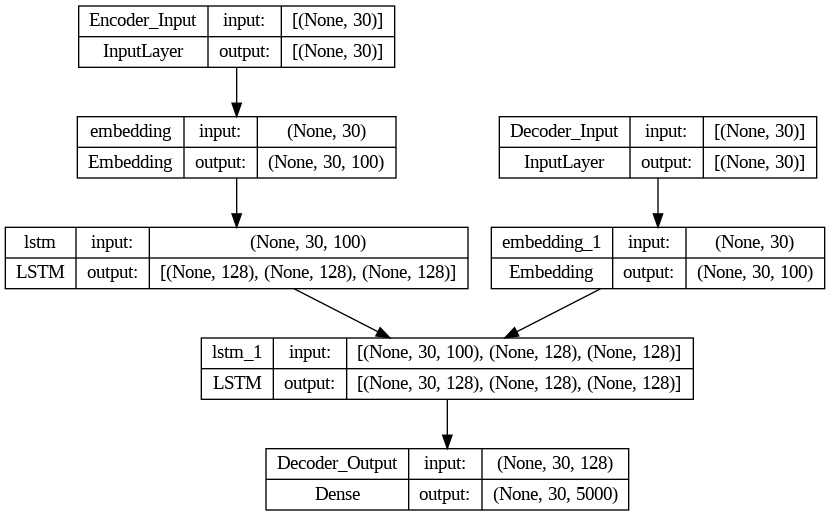

In [22]:
plot_model(model_teacher_forcing, show_shapes=True)

### Train the model

In [23]:
EPOCHS = 300
BATCH_SIZE = 64
history = model_teacher_forcing.fit([encoder_inputs, decoder_inputs],
                    decoder_targets, batch_size=BATCH_SIZE, epochs=EPOCHS,
                   validation_split=0.2)

Epoch 1/300
148/148 [==============================] - 32s 160ms/step - loss: 2.6688 - accuracy: 0.7340 - val_loss: 1.9858 - val_accuracy: 0.7051
Epoch 2/300
148/148 [==============================] - 6s 40ms/step - loss: 1.5014 - accuracy: 0.7844 - val_loss: 1.7748 - val_accuracy: 0.7593
Epoch 3/300
148/148 [==============================] - 4s 29ms/step - loss: 1.3837 - accuracy: 0.8023 - val_loss: 1.6978 - val_accuracy: 0.7624
Epoch 4/300
148/148 [==============================] - 4s 25ms/step - loss: 1.3259 - accuracy: 0.8056 - val_loss: 1.6605 - val_accuracy: 0.7667
Epoch 5/300
148/148 [==============================] - 5s 31ms/step - loss: 1.2886 - accuracy: 0.8095 - val_loss: 1.6422 - val_accuracy: 0.7689
Epoch 6/300
148/148 [==============================] - 4s 28ms/step - loss: 1.2585 - accuracy: 0.8119 - val_loss: 1.6244 - val_accuracy: 0.7703
Epoch 7/300
148/148 [==============================] - 4s 24ms/step - loss: 1.2319 - accuracy: 0.8139 - val_loss: 1.6092 - val_accurac

accuracy, loss 시각화

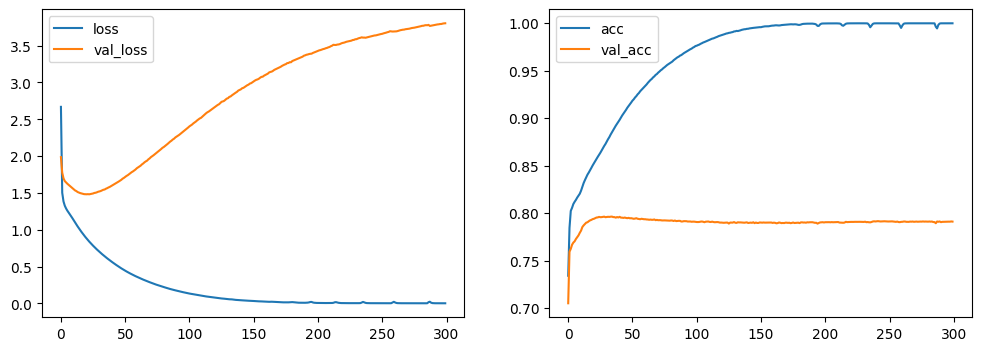

In [24]:
# plot some data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

# accuracies
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [25]:
# save model
model_teacher_forcing.save('s2s.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Make Predictions - Inference phase

- prediction 을 위한 별도의 encoder model
- encoder 의 states 를 initial state 로 받는 decoder model 작성  

- encoder 는 training 단계와 동일하게 input_text 를 입력으로 받고 encoder_states 를 출력으로 하므로 이전에 define 한 encoder_input_ 과 encoder_states 변수 재사용

In [26]:
# Decoder for inference
decoder_state_input_h = Input(shape=(LATENT_DIM,), name='Decoder_hidden_h')
decoder_state_input_c = Input(shape=(LATENT_DIM,), name='Decoder_hidden_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,), name='Decoder_input')
x = embedding_decoder(decoder_inputs_single)

# output, hidden states 를 저장
decoder_outputs, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,    #decoder_model.predict([target_seq] + states_value)
    [decoder_outputs] + decoder_states
)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Decoder_input (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     500100    ['Decoder_input[0][0]']       
                                                                                                  
 Decoder_hidden_h (InputLay  [(None, 128)]                0         []                            
 er)                                                                                              
                                                                                                  
 Decoder_hidden_c (InputLay  [(None, 128)]                0         []                      

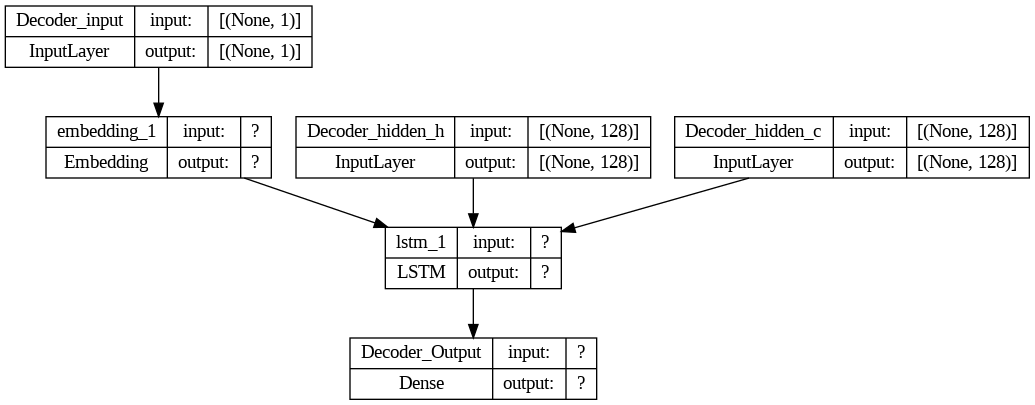

In [27]:
plot_model(decoder_model, show_shapes=True)

### 다음의 inference module 작성
- question 을 encoder 에 입력하여 thought vector 반환
- start token 설정
- 가장 확률 높은 next word 선택
- end token 생성 될 때까지 반복
- predict 결과가 sequence 로 반환되므로 index 를 word 로 변환

In [28]:
def decode_sequence(input_seq, temperature=1.0):
    # 입력된 질문을 encoder 에 입력하여 state vector 생성
    states_value = encoder_model.predict(input_seq)
    # size 1 짜리 빈 target sequence 생성
    target_seq = np.zeros((1, 1))
    # target sequence 의 첫번째 character 를 <s> 로 assign -> 1
    target_seq[0, 0] = 1
    eos = 2  # </s>

    # 답변 생성 시작
    output_ids = []
    for _ in range(max_len_A):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 확률 분포에 따라 단어 샘플링
        output_probs = output_tokens[0, 0, :]

        # 온도 조절 적용
        output_probs = np.log(output_probs + 1e-10) / temperature
        output_probs = np.exp(output_probs) / np.sum(np.exp(output_probs))

        idx = np.random.choice(len(output_probs), p=output_probs)

        if eos == idx:  # End sentence of EOS
            break

        if idx > 0:  # idx 0 은 zero padding 이므로 skip
            output_ids.append(int(idx))

        # 생성된 word 를 decoder 의 다음 input 으로 사용
        target_seq[0, 0] = idx
        # Update states
        states_value = [h, c]

    return output_ids

- sample Q & A test

In [29]:
sp.Load(f'{prefix}.model')

for _ in range(5):
    i = np.random.choice(len(Q_texts))
    input_seq = encoder_inputs[i:i+1]
    response = decode_sequence(input_seq)
    print('-')
    print('질문 :', Q_texts[i])
    print('답변 :', sp.DecodeIds(response))

1/1 [==============================] - 0s 33ms/step
-
질문 : 나 좋아하는 남자애 없나봄. 넘 외로워.
답변 : 좋아하는 사람이 생길 거예요.
1/1 [==============================] - 0s 30ms/step
-
질문 : 학교 가서 어떻게 얼굴 보지
답변 : 선생님이요?
1/1 [==============================] - 0s 18ms/step
-
질문 : 친구랑 비교 돼
답변 : 비교하면 끝도 없어요.
1/1 [==============================] - 0s 17ms/step
-
질문 : 남자친구가 나쁜 의도는 아닌데 표현이 너무 서툴러.
답변 : 더 좋은 표현들로 천천히 고쳐나가봐요.
1/1 [==============================] - 0s 19ms/step
-
질문 : 수학여행가는데 옷 뭐입을까
답변 : 뭘 입어도 멋져요.


In [30]:
txt = "강아지 키울까"
input_sequence = sp.encode_as_ids(txt)
encoder_input = pad_sequences([input_sequence], maxlen=MAX_LEN)

response = decode_sequence(encoder_input)
print('-')
print('질문', txt)
print('답변:', sp.DecodeIds(response))

1/1 [==============================] - 0s 19ms/step
-
질문 강아지 키울까
답변: 책임질 수 있을 때 키워 보세요.


In [32]:
print("챗봇 대화 시작 .....")

while True:
    txt = input("질문 :")
    if txt.lower() == "quit":
        break

    input_sequence = sp.encode_as_ids(txt)
    encoder_input = pad_sequences([input_sequence], maxlen=MAX_LEN)

    answer = decode_sequence(encoder_input)

    print("답변 :", sp.DecodeIds(answer))

챗봇 대화 시작 .....
질문 :배고파
1/1 [==============================] - 0s 20ms/step
답변 : 뭐 좀 챙겨드세요.
질문 :quit
